In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
ticker = 'MSFT'
df = yf.download(ticker,'2020-01-01')

C:\Users\sansi\AppData\Local\Temp\ipykernel_18588\3988902261.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [8]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468285,72.528604,71.223282,71.476622,135480400
2020-01-03,71.763733,72.523762,71.539345,71.696175,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000
2020-01-08,73.153503,73.455103,71.698589,71.698589,132079200
...,...,...,...,...,...
2025-12-08,277.890015,279.670013,276.149994,278.130005,38211800
2025-12-09,277.179993,280.029999,276.920013,278.160004,32193300


<Axes: xlabel='Date'>

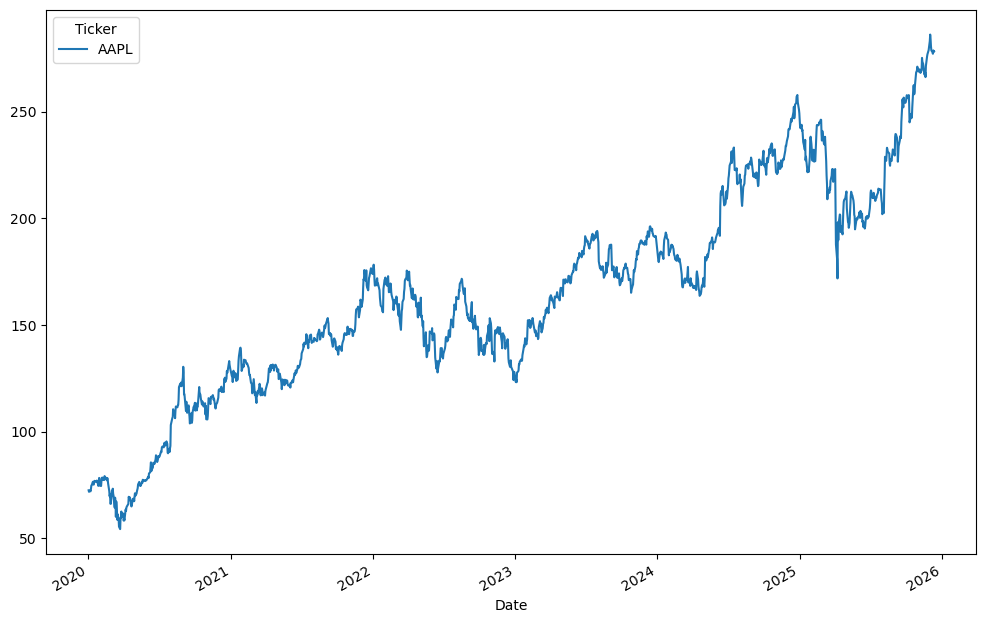

In [9]:
df.Close.plot(figsize=(12,8))

In [87]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [12]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.871575
2020-01-03,-1.885969
2020-01-06,-1.874287
2020-01-07,-1.881237
2020-01-08,-1.857576
...,...
2025-12-08,2.325299
2025-12-09,2.310792
2025-12-10,2.343481


In [88]:
seq_length = 30
data = []

for i in range(len(df)-seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [14]:
data

array([[[-1.87157491],
        [-1.88596927],
        [-1.87428678],
        ...,
        [-1.77289513],
        [-1.73539142],
        [-1.74690433]],

       [[-1.88596927],
        [-1.87428678],
        [-1.88123714],
        ...,
        [-1.73539142],
        [-1.74690433],
        [-1.74650903]],

       [[-1.87428678],
        [-1.88123714],
        [-1.85757553],
        ...,
        [-1.74690433],
        [-1.74650903],
        [-1.77590924]],

       ...,

       [[ 2.13834815],
        [ 2.15263605],
        [ 2.18733389],
        ...,
        [ 2.34348138],
        [ 2.32529853],
        [ 2.31079241]],

       [[ 2.15263605],
        [ 2.18733389],
        [ 2.16631106],
        ...,
        [ 2.32529853],
        [ 2.31079241],
        [ 2.34348138]],

       [[ 2.18733389],
        [ 2.16631106],
        [ 2.1393688 ],
        ...,
        [ 2.31079241],
        [ 2.34348138],
        [ 2.32815848]]])

In [89]:

train_size = int(0.8*len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [59]:
X_train

tensor([[[-1.8716],
         [-1.8860],
         [-1.8743],
         ...,
         [-1.7633],
         [-1.7729],
         [-1.7354]],

        [[-1.8860],
         [-1.8743],
         [-1.8812],
         ...,
         [-1.7729],
         [-1.7354],
         [-1.7469]],

        [[-1.8743],
         [-1.8812],
         [-1.8576],
         ...,
         [-1.7354],
         [-1.7469],
         [-1.7465]],

        ...,

        [[ 1.2633],
         [ 1.2806],
         [ 1.2493],
         ...,
         [ 1.2552],
         [ 1.2326],
         [ 1.2556]],

        [[ 1.2806],
         [ 1.2493],
         [ 1.3163],
         ...,
         [ 1.2326],
         [ 1.2556],
         [ 1.1518]],

        [[ 1.2493],
         [ 1.3163],
         [ 1.3003],
         ...,
         [ 1.2556],
         [ 1.1518],
         [ 1.2346]]])

In [90]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [91]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [92]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [93]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.8190335035324097
25 0.012847023084759712
50 0.004924665670841932
75 0.003932377323508263
100 0.0036254331935197115
125 0.0034048098605126143
150 0.0032129627652466297
175 0.0030634168069809675


In [94]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [95]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [96]:
train_rmse

5.4522247

In [97]:
test_rmse

14.263187

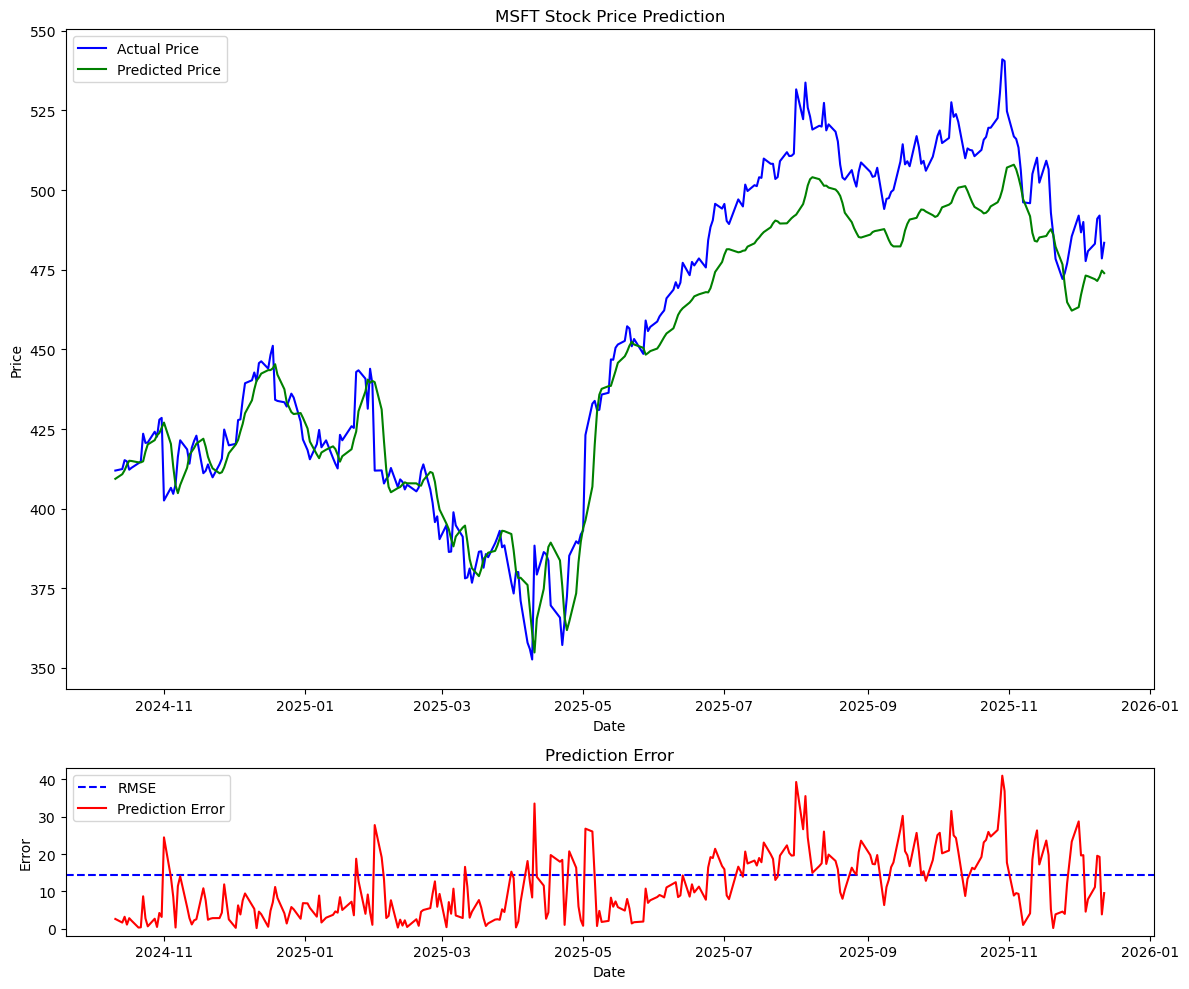

In [98]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()